
Results for BTC:
Average Execution Price: $35182.78
VWAP Benchmark: $39393.36
Execution Cost: -1068.9 bps


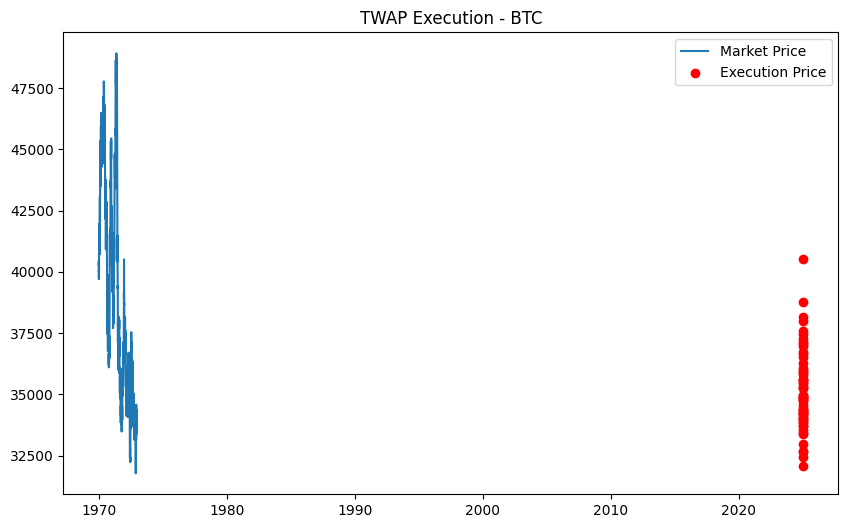


Results for ETH:
Average Execution Price: $1675.01
VWAP Benchmark: $1884.66
Execution Cost: -1112.4 bps


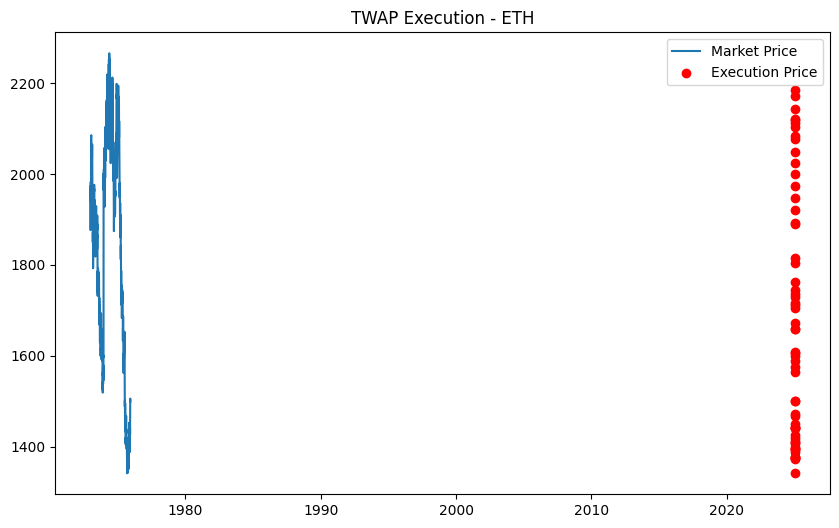

In [1]:
#Let me import the necessary libraries first
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import List, Dict

@dataclass
class Trade:
    timestamp: datetime
    venue: str
    quantity: float
    price: float
    side: str

class MarketDataGenerator:
    def __init__(self, initial_prices: Dict[str, float], num_venues: int = 3, volatility: float = 0.01):
        self.initial_prices = initial_prices
        self.venues = [f"VENUE_{i}" for i in range(num_venues)]
        self.volatility = volatility

    def generate_market_data(self, start_date: datetime, end_date: datetime, freq: str = '1min') -> pd.DataFrame:
        timestamps = pd.date_range(start=start_date, end=end_date, freq=freq)
        data = []

        for asset, initial_price in self.initial_prices.items():
            for venue in self.venues:
                # This will generate price path with realistic volatility
                returns = np.random.normal(0, self.volatility, len(timestamps))
                prices = initial_price * np.exp(np.cumsum(returns))

                # Then its time to generate volume with time-of-day pattern
                base_volume = np.random.poisson(100, len(timestamps))
                time_factors = 1 + 0.5 * np.sin(np.pi * (timestamps.hour + timestamps.minute/60) / 12)
                volumes = base_volume * time_factors

                for t, price, vol in zip(timestamps, prices, volumes):
                    data.append({
                        'timestamp': t,
                        'venue': venue,
                        'asset': asset,
                        'price': price,
                        'bid': price * 0.9995,
                        'ask': price * 1.0005,
                        'volume': vol
                    })

        return pd.DataFrame(data)

class TWAPStrategy:
    def __init__(self, asset: str, quantity: float, start_time: datetime, end_time: datetime):
        self.asset = asset
        self.quantity = quantity
        self.start_time = start_time
        self.end_time = end_time

    def generate_orders(self, num_slices: int) -> List[Dict]:
        slice_quantity = self.quantity / num_slices
        timestamps = pd.date_range(
            start=self.start_time,
            end=self.end_time,
            periods=num_slices
        )

        return [{'timestamp': t, 'quantity': slice_quantity} for t in timestamps]

class ExecutionSimulator:
    def __init__(self, market_data: pd.DataFrame, commission_rate: float = 0.0001):
        self.market_data = market_data
        self.commission_rate = commission_rate

    def execute_strategy(self, strategy: TWAPStrategy, num_slices: int) -> List[Trade]:
        orders = strategy.generate_orders(num_slices)
        trades = []

        for order in orders:
            # This finds the nearest market data point
            market_slice = self.market_data[
                (self.market_data['asset'] == strategy.asset) &
                (self.market_data['timestamp'] <= order['timestamp'])
            ].iloc[-1]

            trades.append(Trade(
                timestamp=order['timestamp'],
                venue=market_slice['venue'],
                quantity=order['quantity'],
                price=market_slice['ask'],  # One can use the ask price for buys
                side='BUY'
            ))

        return trades

class PerformanceAnalyzer:
    @staticmethod
    def calculate_metrics(trades: List[Trade], market_data: pd.DataFrame) -> Dict:
        df_trades = pd.DataFrame([vars(t) for t in trades])

        # This will calculate the VWAP benchmark
        vwap = np.average(
            market_data['price'],
            weights=market_data['volume']
        )

        # Calculating the execution metrics
        avg_exec_price = np.average(df_trades['price'], weights=df_trades['quantity'])
        total_volume = df_trades['quantity'].sum()
        total_cost = (df_trades['price'] * df_trades['quantity']).sum()

        return {
            'avg_execution_price': avg_exec_price,
            'vwap_benchmark': vwap,
            'total_volume': total_volume,
            'total_cost': total_cost,
            'execution_cost_bps': (avg_exec_price - vwap) / vwap * 10000
        }

def run_simulation():
    # Now time to set the simulation parameters
    start_date = datetime.now().replace(hour=9, minute=30)
    end_date = start_date + timedelta(hours=6)
    assets = {'BTC': 40000, 'ETH': 2000}

    # Now I will generate the market data here
    generator = MarketDataGenerator(initial_prices=assets)
    market_data = generator.generate_market_data(start_date, end_date)

    # Time to run this TWAP strategy
    results = {}
    for asset, initial_price in assets.items():
        strategy = TWAPStrategy(asset, quantity=1.0, start_time=start_date, end_time=end_date)
        simulator = ExecutionSimulator(market_data)
        trades = simulator.execute_strategy(strategy, num_slices=60)

        # Analyze performance
        metrics = PerformanceAnalyzer.calculate_metrics(trades, market_data[market_data['asset'] == asset])
        results[asset] = metrics

        print(f"\nResults for {asset}:")
        print(f"Average Execution Price: ${metrics['avg_execution_price']:.2f}")
        print(f"VWAP Benchmark: ${metrics['vwap_benchmark']:.2f}")
        print(f"Execution Cost: {metrics['execution_cost_bps']:.1f} bps")

        # To give a visualization, I will plot execution prices vs market prices
        plt.figure(figsize=(10, 6))
        plt.plot(market_data[market_data['asset'] == asset]['price'], label='Market Price')
        plt.scatter(
            [t.timestamp for t in trades],
            [t.price for t in trades],
            color='red',
            label='Execution Price'
        )
        plt.title(f'TWAP Execution - {asset}')
        plt.legend()
        plt.show()

if __name__ == "__main__":
    run_simulation()